In [1]:
# Perform Google Colab installs (if running in Google Colab)
import os
if True:
#if "COLAB_GPU" in os.environ:
    print("[INFO] Running in Google Colab, installing requirements.")
    !pip install -U torch # requires torch 2.1.1+ (for efficient sdpa implementation)
    !pip install PyMuPDF # for reading PDFs with Python
    !pip install tqdm # for progress bars
    !pip install sentence-transformers # for embedding models
    !pip install accelerate # for quantization model loading
    !pip install bitsandbytes # for quantizing models (less storage space)
    !pip install flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference
    !pip install datasets
    !pip install seaborn
    !pip install spacy

[INFO] Running in Google Colab, installing requirements.
  Using cached flash_attn-2.5.8.tar.gz (2.5 MB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [20 lines of output]
      fatal: not a git repository (or any of the parent directories): .git
      /var/tmp/pip-install-ys1vsj1j/flash-attn_1aede9c9a36a4d379c11e20f7a6f1a85/setup.py:78: UserWarning: flash_attn was requested, but nvcc was not found.  Are you sure your environment has nvcc available?  If you're installing within a container from https://hub.docker.com/r/pytorch/pytorch, only images whose names contain 'devel' will provide nvcc.
        warnings.warn(
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/var/tmp/pip-install-ys1vsj1j/flash-attn_1aede9c9a36a4d379c11e20f7a6f1a85/setup.py", line 134, in <m

In [2]:
# import os
# from google.colab import drive
# drive.mount('/content/drive')

# path = 'Colab Notebooks/NLP/Project'

# os.chdir(f'/content/drive/MyDrive/{path}')
# os.getcwd()

In [3]:
# import pandas as pd

# list_contexts = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/NLP/Project/processed_answers.pkl")
# contexts = [{"text": text} for text in list_contexts]

In [4]:
from datasets import load_dataset

dataset = load_dataset("eli5_category")

/opt/conda/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for eli5_category contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/eli5_category
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [5]:
from spacy.lang.en import English

# Initialize spaCy with the English model
nlp = English()
nlp.add_pipe("sentencizer")

In [6]:
from tqdm import tqdm

contexts = []

# Iterate over each entry in the dataset (adjust subset as needed, e.g., 'train')
for item in tqdm(dataset['test']):
    for text, score in zip(item['answers']['text'], item['answers']['score']):
        # Process the text with spaCy
        doc = nlp(text)

        # Store processed data in the list
        contexts.append({
            "text": text,
            "sentences": [str(sentence) for sentence in list(doc.sents)],
            "sentence_count": len(list(doc.sents)),
            "score": score
        })


100%|██████████| 5411/5411 [00:09<00:00, 598.42it/s]


Now let's turn out list of dictionaries into a DataFrame and get some stats.

In [7]:
import pandas as pd

df = pd.DataFrame(contexts)
df.describe().round(2)

,sentence_count,score
count,13965.00,13965.00
mean,5.89,92.45
std,5.78,874.06
min,1.00,3.00
25%,3.00,4.00
50%,4.00,6.00
75%,7.00,13.00
max,100.00,43303.00


In [8]:
df[:5]

,text,sentences,sentence_count,score
0,The XBox is emulating NES hardware and running...,[The XBox is emulating NES hardware and runnin...,4,13
1,"In that case, it's probably on purpose - they ...","[In that case, it's probably on purpose - they...",4,3
2,"Because if they were pulled taut, then a stron...","[Because if they were pulled taut, then a stro...",2,9
3,"There are a few reasons. First, they're metal....","[There are a few reasons., First, they're meta...",5,6
4,The lines have mass. So there is something tha...,"[The lines have mass., So there is something t...",8,4


### Chunking sentences together

In [9]:
from tqdm import tqdm

# Define the number of sentences per chunk
num_sentence_chunk_size = 5

def split_list(input_list: list, slice_size: int) -> list[list[str]]:
    """
    Recursively splits a list into sublists of a specified size.

    Args:
    input_list (list): The list to split.
    slice_size (int): The number of elements each sublist should have.

    Returns:
    list[list[str]]: A list of sublists, where each sublist has up to `slice_size` elements.
    """
    if not isinstance(input_list, list):
        raise ValueError("Input must be a list.")
    if not isinstance(slice_size, int) or slice_size <= 0:
        raise ValueError("Slice size must be a positive integer.")

    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through each item in contexts and split the sentences into chunks
for item in tqdm(contexts):
    # Ensure that each item has the 'sentences' key and it is a list
    if 'sentences' in item and isinstance(item['sentences'], list):
        item['sentence_chunks'] = split_list(input_list=item['sentences'],
                                             slice_size=num_sentence_chunk_size)
        item['num_chunks'] = len(item['sentence_chunks'])
    else:
        # Log or handle items that do not have a 'sentences' key or where 'sentences' is not a list
        print(f"Warning: Item without 'sentences' or 'sentences' is not a list: {item}")


100%|██████████| 13965/13965 [00:00<00:00, 290012.11it/s]


In [10]:
import random

random.sample(contexts, k=1)

[{'text': 'Slot head screws are (were) often used in machinery or areas that would be painted over because one can use the same tool (screw driver) to both clean out the drive slot and turn it',
  'sentences': ['Slot head screws are (were) often used in machinery or areas that would be painted over because one can use the same tool (screw driver) to both clean out the drive slot and turn it'],
  'sentence_count': 1,
  'score': 6,
  'sentence_chunks': [['Slot head screws are (were) often used in machinery or areas that would be painted over because one can use the same tool (screw driver) to both clean out the drive slot and turn it']],
  'num_chunks': 1}]

In [11]:
# Create a DataFrame to get stats
df = pd.DataFrame(contexts)
df.describe().round(2)

,sentence_count,score,num_chunks
count,13965.00,13965.00,13965.00
mean,5.89,92.45,1.60
std,5.78,874.06,1.15
min,1.00,3.00,1.00
25%,3.00,4.00,1.00
50%,4.00,6.00,1.00
75%,7.00,13.00,2.00
max,100.00,43303.00,20.00


### Splitting each chunk into its own item

We'd like to embed each chunk of sentences into its own numerical representation.

So to keep things clean, let's create a new list of dictionaries each containing a single chunk of sentences with relative information such as page number as well statistics about each chunk.

In [12]:
df["sentence_chunks"][0]

[['The XBox is emulating NES hardware and running the emulation at a set speed.',
  'If it ran it at as fast as possible, then it would be several times faster than the original NES game and would be unplayable.',
  "I can't speak for Mega Man exactly, but older games tended to run on a cycle locked to the screen refresh which was a fixed 60Hz or 50Hz.",
  'There was only one piece of hardware they ran on, so there was no need to adjust for different hardware speeds.']]

In [13]:
import re
from tqdm import tqdm

# Initialize a new list to store each chunk as a separate dictionary
chunks_separated = []

for item in tqdm(contexts):
    # Check if there are sentence chunks to process
    if "sentence_chunks" in item:
        for sentence_chunk in item["sentence_chunks"]:
            # Create a new dictionary for each chunk
            chunk_dict = {}

            # Join the sentences into a single string to form a coherent chunk
            joined_sentence_chunk = " ".join(sentence_chunk).strip()
            joined_sentence_chunk = re.sub(r'\.(?=\s*[A-Z])', '. ', joined_sentence_chunk)

            # Populate the chunk dictionary with details
            chunk_dict["sentence_chunk"] = joined_sentence_chunk
            chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
            chunk_dict["chunk_word_count"] = len(joined_sentence_chunk.split())
            chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) // 4  # Approximate token count


            # Append the chunk dictionary to the new list
            chunks_separated.append(chunk_dict)

# Now, `chunks_separated` contains a list of dictionaries, each representing a single chunk
print(f"Total number of separated chunks: {len(chunks_separated)}")
# Optionally, print the first few to check
print(chunks_separated[:3])  # Print the first three chunks to verify


100%|██████████| 13965/13965 [00:00<00:00, 70246.03it/s]


Total number of separated chunks: 22397
[{'sentence_chunk': "The XBox is emulating NES hardware and running the emulation at a set speed.  If it ran it at as fast as possible, then it would be several times faster than the original NES game and would be unplayable.  I can't speak for Mega Man exactly, but older games tended to run on a cycle locked to the screen refresh which was a fixed 60Hz or 50Hz.  There was only one piece of hardware they ran on, so there was no need to adjust for different hardware speeds.", 'chunk_char_count': 456, 'chunk_word_count': 88, 'chunk_token_count': 114}, {'sentence_chunk': 'In that case, it\'s probably on purpose - they want to emulate the experience as closely as possible, even including the slowdown and sprite flickering.  Some emulators let you turn it off, but it\'s usually turned on by default.  In other cases, like if you\'re trying to emulate PS2 games on your PC, the game might just run really slow in general.  Even though your PC is way more 

In [14]:
# View a random sample
random.sample(chunks_separated, k=1)

[{'sentence_chunk': 'The major urban area of Phoenix for example is over 60 miles across.  Commutes of 20mi+ are very common.  Not practical for mass transit use.  Mass transit is slow and even with rush hour traffic it is typically much faster to drive than to take public transit.  Vehicle ownership is also seen as a measure of success in America.',
  'chunk_char_count': 329,
  'chunk_word_count': 59,
  'chunk_token_count': 82}]

In [15]:
# Get stats about our chunks
df = pd.DataFrame(chunks_separated)
df.head()

,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count
0,The XBox is emulating NES hardware and running...,456,88,114
1,"In that case, it's probably on purpose - they ...",539,98,134
2,"Because if they were pulled taut, then a stron...",239,44,59
3,"There are a few reasons. First, they're metal...",310,51,77
4,The lines have mass. So there is something th...,302,59,75


### Filter out low token count sentences (probably not too much meaning

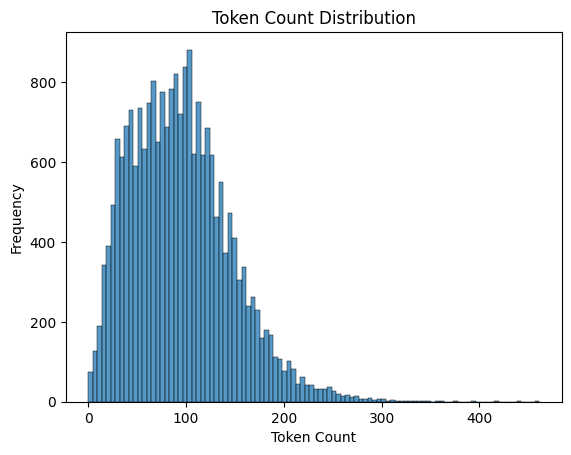

95th Percentile Cutoff: 185.0
Remaining chunks after cutoff: 21296


In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['chunk_token_count'], bins=100)
plt.title('Token Count Distribution')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.show()

# Analyzing 95th percentile
cutoff = df['chunk_token_count'].quantile(0.95)
print(f"95th Percentile Cutoff: {cutoff}")

# Removing entries with a token count higher than the cutoff
filtered_df = df[df['chunk_token_count'] <= cutoff]
print(f"Remaining chunks after cutoff: {len(filtered_df)}")


In [17]:
# Print lower percentiles
for percentile in [5, 10, 15, 20, 25]:
    value = df['chunk_token_count'].quantile(percentile / 100.0)
    print(f"{percentile}th percentile: {value}")

5th percentile: 23.0
10th percentile: 32.0
15th percentile: 40.0
20th percentile: 48.0
25th percentile: 55.0


In [18]:
# Show random chunks with under 20 tokens in length
min_token_length = 20
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 4 | Text: You rich bastards.
Chunk token count: 17 | Text: It's all dependent on the material and its physical characters.  URL_0
Chunk token count: 19 | Text: The smokestack in your video was presumably supposed to pancake straight down.
Chunk token count: 8 | Text: Curtains are a HUGE fire hazard.
Chunk token count: 6 | Text: Its different per platform


In [19]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'sentence_chunk': "The XBox is emulating NES hardware and running the emulation at a set speed.  If it ran it at as fast as possible, then it would be several times faster than the original NES game and would be unplayable.  I can't speak for Mega Man exactly, but older games tended to run on a cycle locked to the screen refresh which was a fixed 60Hz or 50Hz.  There was only one piece of hardware they ran on, so there was no need to adjust for different hardware speeds.",
  'chunk_char_count': 456,
  'chunk_word_count': 88,
  'chunk_token_count': 114},
 {'sentence_chunk': 'In that case, it\'s probably on purpose - they want to emulate the experience as closely as possible, even including the slowdown and sprite flickering.  Some emulators let you turn it off, but it\'s usually turned on by default.  In other cases, like if you\'re trying to emulate PS2 games on your PC, the game might just run really slow in general.  Even though your PC is way more powerful than a PS2, it has to "t

### Embedding text chunks

To do so, we'll use the [`sentence-transformers`](https://www.sbert.net/docs/installation.html) library which contains many pre-trained embedding models.

Specifically, we'll get the `all-mpnet-base-v2` model.

In [20]:
# Requires !pip install sentence-transformers
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device="cpu") # choose the device to load the model to (note: GPU will often be *much* faster than CPU)

# Create a list of sentences to turn into numbers
sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence: The Sentences Transformers library provides an easy and open-source way to create embeddings.
Embedding: [-2.07982697e-02  3.03164832e-02 -2.01217849e-02  6.86484650e-02
 -2.55256221e-02 -8.47686455e-03 -2.07225574e-04 -6.32377118e-02
  2.81606894e-02 -3.33353989e-02  3.02633960e-02  5.30721806e-02
 -5.03527038e-02  2.62288321e-02  3.33313718e-02 -4.51577231e-02
  3.63044813e-02 -1.37122418e-03 -1.20171458e-02  1.14947259e-02
  5.04510924e-02  4.70856987e-02  2.11913940e-02  5.14606535e-02
 -2.03746483e-02 -3.58889401e-02 -6.67763175e-04 -2.94393823e-02
  4.95859198e-02 -1.05639677e-02 -1.52014112e-02 -1.31758570e-03
  4.48197424e-02  1.56023465e-02  8.60379430e-07 -1.21392624e-03
 -2.37978697e-02 -9.09368275e-04  7.34484056e-03 -2.53933994e-03
  5.23370504e-02 -4.68043424e-02  1.66214760e-02  4.71579395e-02
 -4.15599644e-02  9.01976076e-04  3.60277519e-02  3.42214219e-02
  9.68227163e-02  5.94829023e-02 -1.64984372e-02 -3.51249315e-02
  5.92516130e-03 -7.07903586e-04 -2.4103

In [21]:
single_sentence = "Yo! How cool are embeddings?"
single_embedding = embedding_model.encode(single_sentence)
print(f"Sentence: {single_sentence}")
print(f"Embedding:\n{single_embedding}")
print(f"Embedding size: {single_embedding.shape}")

Sentence: Yo! How cool are embeddings?
Embedding:
[-1.97448116e-02 -4.51077055e-03 -4.98486962e-03  6.55444860e-02
 -9.87674389e-03  2.72836108e-02  3.66426110e-02 -3.30219767e-03
  8.50078650e-03  8.24952498e-03 -2.28497703e-02  4.02430147e-02
 -5.75200692e-02  6.33691847e-02  4.43207137e-02 -4.49506715e-02
  1.25284614e-02 -2.52011847e-02 -3.55293006e-02  1.29559003e-02
  8.67021922e-03 -1.92917790e-02  3.55635840e-03  1.89505480e-02
 -1.47128161e-02 -9.39848833e-03  7.64175924e-03  9.62184742e-03
 -5.98920882e-03 -3.90168726e-02 -5.47824651e-02 -5.67456335e-03
  1.11644426e-02  4.08067517e-02  1.76319088e-06  9.15305596e-03
 -8.77257995e-03  2.39382870e-02 -2.32784245e-02  8.04999843e-02
  3.19176875e-02  5.12598455e-03 -1.47708450e-02 -1.62525177e-02
 -6.03213124e-02 -4.35689688e-02  4.51211594e-02 -1.79053694e-02
  2.63366792e-02 -3.47866528e-02 -8.89172778e-03 -5.47675341e-02
 -1.24372439e-02 -2.38606706e-02  8.33496898e-02  5.71241677e-02
  1.13328267e-02 -1.49595067e-02  9.2037

Our embedding has a shape of `(768,)`

> **Note:** No matter the size of the text input to our `all-mpnet-base-v2` model, it will be turned into an embedding size of `(768,)`. This value is fixed. So whether a sentence is 1 token long or 1000 tokens long, it will be truncated/padded with zeros to size 384 and then turned into an embedding vector of size `(768,)`. Of course, other embedding models may have different input/output shapes.


In [22]:
# path = '/content/drive/MyDrive/Colab Notebooks/NLP/Project'
# os.chdir(path)
# os.getcwd()

In [23]:
import os
import pickle
from tqdm.auto import tqdm

# Path to the file where the embeddings will be stored
data_filename = 'pages_and_chunks_embeddings.pkl'  # Define the filename

# Function to embed and save data if not already saved
def embed_and_save_data(data, filename):
    # Load the embedding model
    # Assuming `embedding_model` is defined and loaded elsewhere in your code
    embedding_model.to("cpu")
    
    # Embed each chunk one by one
    for item in tqdm(data):
        item["embedding"] = embedding_model.encode(item["sentence_chunk"])
    
    # Save the data using pickle
    with open(filename, 'wb') as file:
        pickle.dump(data, file)
    print(f"Data embedded and saved to '{filename}'")

# Check if the data file already exists
if os.path.exists(data_filename):
    # Load the data if it already exists
    with open(data_filename, 'rb') as file:
        pages_and_chunks_over_min_token_len = pickle.load(file)
    print(f"Data loaded from '{data_filename}'")
else:
    # Otherwise, process and save the data
    embed_and_save_data(pages_and_chunks_over_min_token_len, data_filename)


Data loaded from 'pages_and_chunks_embeddings.pkl'


In [24]:
# %%time

# # Send the model to the GPU
# embedding_model.to("cuda") # requires a GPU installed, for reference on my local machine, I'm using a NVIDIA RTX 4090

# # Create embeddings one by one on the GPU
# for item in tqdm(pages_and_chunks_over_min_token_len):
#     item["embedding"] = embedding_model.encode(item["sentence_chunk"])

### Save embeddings to file

In [25]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [26]:
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,The XBox is emulating NES hardware and running...,456,88,114,[-2.15684958e-02 -3.29913981e-02 -3.74654382e-...
1,"In that case, it's probably on purpose - they ...",539,98,134,[-5.21687679e-02 -1.29516320e-02 -5.54381758e-...
2,"Because if they were pulled taut, then a stron...",239,44,59,[-3.84662300e-02 -4.87860851e-02 3.15849739e-...
3,"There are a few reasons. First, they're metal...",310,51,77,[-2.76063345e-02 -9.72803906e-02 -2.12281160e-...
4,The lines have mass. So there is something th...,302,59,75,[ 1.75171345e-03 -6.58367872e-02 -4.83261794e-...


## 2. RAG - Search and Answer

### Similarity search

In [27]:
import random

import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([21541, 768])

In [28]:
text_chunks_and_embedding_df.head()

,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,The XBox is emulating NES hardware and running...,456,88,114,"[-0.0215684958, -0.0329913981, -0.0374654382, ..."
1,"In that case, it's probably on purpose - they ...",539,98,134,"[-0.0521687679, -0.012951632, -0.0554381758, 0..."
2,"Because if they were pulled taut, then a stron...",239,44,59,"[-0.03846623, -0.0487860851, 0.00315849739, 0...."
3,"There are a few reasons. First, they're metal...",310,51,77,"[-0.0276063345, -0.0972803906, -0.021228116, 0..."
4,The lines have mass. So there is something th...,302,59,75,"[0.00175171345, -0.0658367872, -0.00483261794,..."


In [29]:
embeddings[0]

tensor([-2.1568e-02, -3.2991e-02, -3.7465e-02,  5.5965e-02, -9.5515e-03,
         7.6541e-02, -3.5977e-02,  4.2866e-02, -5.4287e-02, -2.4998e-03,
        -5.4825e-02,  4.4280e-02,  3.7865e-02,  6.6876e-03, -4.7015e-02,
         9.5823e-03,  6.1314e-03,  1.9698e-02,  1.8276e-03, -1.1714e-02,
         2.2311e-02, -9.3213e-03, -2.4540e-02,  4.9592e-03, -7.6966e-03,
        -8.4572e-03,  5.7527e-02,  3.2676e-02, -1.7226e-02,  2.9777e-03,
        -7.5077e-03, -1.7565e-02,  3.8572e-02, -2.6700e-02,  2.0631e-06,
         2.3710e-02,  2.1699e-02, -2.7641e-02,  7.2531e-03,  7.2192e-02,
         6.7162e-02, -5.5212e-04,  1.5303e-02,  3.9382e-02, -8.0051e-04,
        -1.2492e-02, -1.8803e-02, -3.0508e-02,  1.2358e-03,  3.5293e-02,
        -1.4148e-02,  5.8195e-02, -6.1536e-02, -1.7600e-02, -6.0312e-02,
        -7.9643e-04, -6.1757e-02,  4.3489e-02,  5.2831e-02,  6.2814e-02,
        -1.7493e-02, -2.1448e-02, -1.8759e-02,  2.6474e-02, -7.5198e-02,
        -6.9528e-02,  8.3606e-02,  2.4292e-02, -6.9

In [30]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device) # choose the device to load the model to

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [31]:
# 1. Define the query
# Note: This could be anything.
query = "touchscreen"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples
# Note: It's important to embed query with the same model you embedded your examples with.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Get similarity scores with the dot product (we'll time this for fun)
from time import perf_counter as timer

dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: touchscreen


torch.return_types.topk(
values=tensor([0.6369, 0.6349, 0.6149, 0.6052, 0.6017]),
indices=tensor([12844,  8562, 12842,  7732, 12846]))

In [32]:
# Define helper function to print wrapped text
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [33]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    #print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'touchscreen'

Results:
Score: 0.6369
Text:
Modern touch screens are capacitive, they detect changes in an electrical field
just above the screen caused by your finger.


Score: 0.6349
Text:
There are two types of touch screens, resistive and capacitive.  Resistive works
by having multiple layers of glass and diodes, so when you push down on the
touch screen, it activates the diodes underneath transferring a message to the
CPU saying "there's a touch in X,Y".  It works via pressure on the screen.
Which is why you can use old ATMs with gloves, and could use literally anything
as a stylus for your Nintendo DS.  Capacitive touch screens are different in
that they require an electrical conduit to register input, so tapping your
finger against the screen allows the hardware to find where the current was
completed and tell the CPU where the screen was touched.


Score: 0.6149
Text:
There are two types of touch screens.  Resistive and Capacitive.  Resistive
types are the ones you see o

The workflow is:

`ingest documents -> split into chunks -> embed chunks -> make a query -> embed the query -> compare query embedding to chunk embeddings`

That's the **retrieval** part of Retrieval Augmented Generation (RAG).

### Similarity measures: dot product and cosine similarity

In our case, our embedding model `all-mpnet-base-v2` outputs normalized outputs (see the [Hugging Face model card](https://huggingface.co/sentence-transformers/all-mpnet-base-v2#usage-huggingface-transformers) for more on this) so dot product and cosine similarity return the same results. However, dot product is faster due to not need to perform a normalize step.

### Functionizing semantic search pipeline

In [34]:
import time
import textwrap
from sentence_transformers import SentenceTransformer
import torch

def retrieve_relevant_resources(query: str, embeddings: torch.tensor, model: SentenceTransformer=embedding_model, n_resources_to_return: int=5, print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """
    # Embed the query
    query_embedding = model.encode(query, convert_to_tensor=True)

    # Get dot product scores on embeddings
    start_time = time.time()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = time.time()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time - start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores, k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str, embeddings: torch.tensor, chunks: list[dict] = pages_and_chunks, n_resources_to_return: int=5):
    """
    Takes a query, retrieves the most relevant resources, and prints them out in descending order.
    Assumes 'chunks' contains at least a 'sentence_chunk' key for each entry.
    """
    scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings, n_resources_to_return=n_resources_to_return)

    print(f"Query: '{query}'\nResults:")
    for score, index in zip(scores, indices):
        print(f"Score: {score.item():.4f}")  # Ensure score is printed as a float
        print("Text:")
        print(textwrap.fill(chunks[index]["sentence_chunk"], width=80))  # Wrap text for better readability
        print("\n")

In [35]:
query = "touchscreen"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

[INFO] Time taken to get scores on 21541 embeddings: 0.00256 seconds.


(tensor([0.6369, 0.6349, 0.6149, 0.6052, 0.6017]),
 tensor([12844,  8562, 12842,  7732, 12846]))

In [36]:
# Print out the texts of the top scores
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

[INFO] Time taken to get scores on 21541 embeddings: 0.00160 seconds.
Query: 'touchscreen'
Results:
Score: 0.6369
Text:
Modern touch screens are capacitive, they detect changes in an electrical field
just above the screen caused by your finger.


Score: 0.6349
Text:
There are two types of touch screens, resistive and capacitive.  Resistive works
by having multiple layers of glass and diodes, so when you push down on the
touch screen, it activates the diodes underneath transferring a message to the
CPU saying "there's a touch in X,Y".  It works via pressure on the screen.
Which is why you can use old ATMs with gloves, and could use literally anything
as a stylus for your Nintendo DS.  Capacitive touch screens are different in
that they require an electrical conduit to register input, so tapping your
finger against the screen allows the hardware to find where the current was
completed and tell the CPU where the screen was touched.


Score: 0.6149
Text:
There are two types of touch screen

In [37]:
from huggingface_hub import notebook_login

# Login to Hugging Face in the notebook to use the API token
notebook_login()

In [38]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from huggingface_hub import notebook_login


# 1. Pick a model we'd like to use
model_id = "mistralai/Mistral-7B-Instruct-v0.2"

# 2. Instantiate tokenizer (tokenizer turns text into numbers ready for the model)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 3. Instantiate the model, specifying to use CPU-friendly settings
llm_model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=model_id,
    torch_dtype=torch.float32,  # Use float32 for CPU to ensure compatibility
    low_cpu_mem_usage=True  # Enable this to minimize memory usage by the CPU
)

# 4. Explicitly set the model to use CPU
llm_model.to("cpu")

print("[INFO] Model and tokenizer are loaded and configured for CPU usage.")


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

[INFO] Model and tokenizer are loaded and configured for CPU usage.


We've got an LLM!

Let's check it out.

In [39]:
llm_model

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
    (norm): MistralRMSNorm(

In [40]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

7241732096

In [41]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.

    See: https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    """
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 30040678400,
 'model_mem_mb': 28649.02,
 'model_mem_gb': 27.98}

### Generating text with our LLM

We can generate text with our LLM `model` instance by calling the [`generate()` method](https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig) (this method has plenty of options to pass into it alongside the text) on it and passing it a tokenized input.

The tokenized input comes from passing a string of text to our `tokenizer`.

It's important to note that you should use a tokenizer that has been paired with a model.

Otherwise if you try to use a different tokenizer and then pass those inputs to a model, you will likely get errors/strange results.

For some LLMs, there's a specific template you should pass to them for ideal outputs.

For example, the `gemma-7b-it` model has been trained in a dialogue fashion (instruction tuning).

In this case, our `tokenizer` has a [`apply_chat_template()` method](https://huggingface.co/docs/transformers/main/en/internal/tokenization_utils#transformers.PreTrainedTokenizerBase.apply_chat_template) which can prepare our input text in the right format for the model.

Let's try it out.

> **Note:** The following demo has been modified from the Hugging Face model card for [Gemma 7B](https://huggingface.co/google/gemma-7b-it). Many similar demos of usage are available on the model cards of similar models.

In [42]:
input_text = "How does touchscreen work?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
How does touchscreen work?

Prompt (formatted):
<s>[INST] How does touchscreen work? [/INST]


In [43]:
%%time

# Tokenize the input text (turn it into numbers) and send it to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to("cpu")
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
# See generate docs: https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256) # define the maximum number of new tokens to create
print(f"Model output (tokens):\n{outputs[0]}\n")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Model input (tokenized):
{'input_ids': tensor([[    1,     1,   733, 16289, 28793,  1602,  1235,  4814,  8555,   771,
         28804,   733, 28748, 16289, 28793]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

Model output (tokens):
tensor([    1,     1,   733, 16289, 28793,  1602,  1235,  4814,  8555,   771,
        28804,   733, 28748, 16289, 28793,   330,  4814,  8555,   349,   396,
         2787,  3895,   369,  5976,  5443,   298, 14113,   395,   396, 13176,
         8809,  4971,   486, 20421,   272,  4921,   395,   264,  9728,   442,
          264,   341,  2951,   381, 28723,   415,  4814,  8555,  5514,  9105,
         1074,   272,  1305,   302,  3754,   778,   264,  7153,  7528, 28725,
          690,   272,  3895,   541,   868,  7190,   304,  9421,   298, 28723,
           13,    13,  5816,   460,  2856,  4514,   302,  4814,  8555, 14880,
        28725,   562,   272,  1080,  3298,  4413,   460, 17025,  2468,   304,
        14905,   495, 28723,    13

In [44]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<s><s> [INST] How does touchscreen work? [/INST] A touchscreen is an input device that allows users to interact with an electronic visual interface by touching the screen with a finger or a stylus. The touchscreen technology converts the point of contact into a digital signal, which the device can then interpret and respond to.

There are several types of touchscreen technologies, but the most common ones are capacitive and resistive.

Capacitive touchscreens work by detecting the change in electrical charge when a conductive object, such as a finger, comes into contact with the screen. The screen is covered with a layer of conductive material, such as indium tin oxide (ITO), which creates an electrical field. When a user touches the screen, the electrical charge at that point changes, and the touchscreen controller can detect the location of the touch.

Resistive touchscreens, on the other hand, work by detecting the pressure applied to the screen. The screen c

In [45]:
print(f"Input text: {input_text}\n")
print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('<bos>', '').replace('<eos>', '')}")

Input text: How does touchscreen work?

Output text:
<s><s> [INST] How does touchscreen work? [/INST] A touchscreen is an input device that allows users to interact with an electronic visual interface by touching the screen with a finger or a stylus. The touchscreen technology converts the point of contact into a digital signal, which the device can then interpret and respond to.

There are several types of touchscreen technologies, but the most common ones are capacitive and resistive.

Capacitive touchscreens work by detecting the change in electrical charge when a conductive object, such as a finger, comes into contact with the screen. The screen is covered with a layer of conductive material, such as indium tin oxide (ITO), which creates an electrical field. When a user touches the screen, the electrical charge at that point changes, and the touchscreen controller can detect the location of the touch.

Resistive touchscreens, on the other hand, work by detecting the pressure applie

In [46]:
# Manually created question list
manual_questions = [
    "How does touchscreen work?"
]

query_list = manual_questions

And now let's check if our `retrieve_relevant_resources()` function works with our list of queries.

In [47]:
import random
query = random.choice(query_list)

print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: How does touchscreen work?
[INFO] Time taken to get scores on 21541 embeddings: 0.00565 seconds.


(tensor([0.7625, 0.7511, 0.7348, 0.7097, 0.7064]),
 tensor([10888,  8562,  7732, 12846, 12842]))

### Augmenting prompt with context items

In [48]:
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    # Join context items into one dotted paragraph
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    # Create a base prompt with examples to help the model
    # Note: this is very customizable, I've chosen to use 3 examples of the answer style we'd like.
    # We could also write this in a txt file and import it in if we wanted.
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""

    # Update base prompt with context items and query
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

In [49]:
query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)

# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format prompt with context items
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: How does touchscreen work?
[INFO] Time taken to get scores on 21541 embeddings: 0.00255 seconds.
<s>[INST] Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.

Now use

In [50]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cpu")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # lower temperature = more deterministic outputs, higher temperature = more creative outputs
                             do_sample=True, # whether or not to use sampling, see https://huyenchip.com/2024/01/16/sampling.html for more
                             max_new_tokens=256) # how many new tokens to generate from prompt

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Query: How does touchscreen work?
RAG answer:
<s><s> [INST] Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.

Now use the following context items to answer the user query:

In [51]:
import re

def clean_text(text):
    # Remove special control characters
    text = re.sub(r"<\|?bos\|?>", "", text)  # Remove any variations of beginning of string tokens
    text = re.sub(r"<\|?eos\|?>", "", text)  # Remove any variations of end of string tokens
    text = re.sub(r"<s>", "", text)  # Remove specific separator tokens if used by your model
    text = re.sub(r"\[/?INST\]", "", text)  # Remove instruction tokens used in the output

    # Optionally, strip out additional unwanted patterns or whitespace
    text = re.sub(r"\s+", " ", text).strip()  # Collapse multiple spaces to one and trim the text
    
    return text


In [52]:
def ask(query,
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context, and generates an answer to the query based on the relevant resources.
    """
    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings)

    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu() # return score back to CPU

    # Format the prompt with context items
    prompt = prompt_formatter(query=query, context_items=context_items)

    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cpu")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)

    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Replace special tokens and unnecessary help message, then clean text
        output_text = output_text.replace(prompt, "")
        output_text = clean_text(output_text)  # Clean the output text using the clean_text function

    # Only return the answer without the context items
    if return_answer_only:
        return output_text

    return output_text, context_items

In [53]:
query = random.choice(query_list)
print(f"Query: {query}")

# Answer query with context and return context
answer, context_items = ask(query=query,
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)

print(f"Answer:\n")
print_wrapped(answer)
print(f"Context items:")
context_items

Query: How does touchscreen work?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INFO] Time taken to get scores on 21541 embeddings: 0.00286 seconds.
Answer:

Based on the following context items, please answer the query. Give yourself
room to think by extracting relevant passages from the context before answering
the query. Don't return the thinking, only return the answer. Make sure your
answers are as explanatory as possible. Use the following examples as reference
for the ideal answer style. Example 1: Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and
Vitamin K. These vitamins are absorbed along with fats in the diet and can be
stored in the body's fatty tissue and liver for later use. Vitamin A is
important for vision, immune function, and skin health. Vitamin D plays a
critical role in calcium absorption and bone health. Vitamin E acts as an
antioxidant, protecting cells from damage. Vitamin K is essential for blood
clotting and bone metabolism. Now use the following context items to answe

[{'sentence_chunk': "In a nutshell. 2 different types of touch screens i'm familar with.. there is resistive which locate the touch by pressing on the screen (like the old mall kiosks and older ATM machines) causing it to deform the rubber-like top layer registering the layer touching the detection surface underneath. & # x200B; Then the now more common 'capacitive' touch screen found on newer devices. this is likely the more interesting one to you.  So... the screen is covered in an electrically charged layer that, when your finger touches the screen, registers a voltage drop as your finger completes the circuit at the precise touch location the drop happened.",
  'chunk_char_count': 648,
  'chunk_word_count': 108,
  'chunk_token_count': 162,
  'embedding': array([-1.32585419e-02, -1.10092945e-01, -2.10858155e-02, -1.83218555e-03,
          1.65647864e-02,  3.20775472e-02,  1.44350622e-02, -1.17559750e-02,
          5.66424988e-02,  1.90146861e-03, -1.62780713e-02, -1.95644256e-02,
  